In [1]:
import torch
from src.myChatGPT import *
from src.metrics import *
#from src.exp_weighted_pairs import *

import matplotlib.pyplot as plt
import numpy as np



 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [2]:
if False:
    data=torch.tensor([9,9,9,9,0,0,0,1,2])
    config.context_size = 5
    vocab_size = 3
    training_set = CustomDataset(data, config.context_size)
    training_generator = torch.utils.data.DataLoader(training_set, batch_size = 2, shuffle=True)  


print(data.shape)


torch.Size([1115394])


In [3]:
def generate_bigrams(vocab_size, data):
    return torch.concatenate([data[:-1].unsqueeze(1),data[1:].unsqueeze(1)], dim=1) 

def generate_bigrams_id(vocab_size, data):
    return generate_bigrams(vocab_size, data) @ torch.tensor([1,vocab_size])

def count_sequence_of_bigrams(vocab_size, data):
    a = generate_bigrams_id(vocab_size, data)
    return torch.zeros(vocab_size*vocab_size, dtype=torch.long).scatter_add(0, a, torch.ones_like(a))

def plot_pairs(dist, title):
    fig, ax = plt.subplots(figsize=(15,3))
    plt.bar(range(len(dist)), dist)
    plt.title(title)
    plt.ylabel('count')
    plt.show()

In [4]:
def generate_weights(vocab_size, data, att_size):
    print(data)
    bigram_list = generate_bigrams(vocab_size, data[att_size-1:])
    print(f"bigram_list {bigram_list}")
    bigram_list_id = generate_bigrams_id(vocab_size, data[att_size-1:])
    print(bigram_list_id)

    dist = count_sequence_of_bigrams(vocab_size, data[att_size-1:])
    weights = 1.0/dist
    weights[weights == float("Inf")] = 0
    print(f"weights {weights}")

    print(f"weights {weights[bigram_list_id]}")
    return weights[bigram_list_id]

weights = generate_weights(vocab_size, training_data, config.context_size)
print(len(weights))

tensor([18, 47, 56,  ..., 43, 56, 43])
bigram_list tensor([[ 0, 35],
        [35, 43],
        [43,  1],
        ...,
        [46, 43],
        [43, 56],
        [56, 43]])
tensor([2275, 2830,  108,  ..., 2841, 3683, 2851])
weights tensor([1.5926e-04, 5.0000e-01, 9.0009e-04,  ..., 0.0000e+00, 0.0000e+00,
        1.6667e-01])
weights tensor([4.1017e-04, 2.3202e-03, 3.9994e-05,  ..., 6.0924e-05, 9.4724e-05,
        1.1288e-04])
1003598


In [9]:
from torch.utils.data import WeightedRandomSampler
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)
weighted_training_generator = torch.utils.data.DataLoader(training_set, sampler=sampler, batch_size = config.batch_size)  
#for _,yy in weighted_training_generator:
#    print(yy[:,-2:].T)

1003598


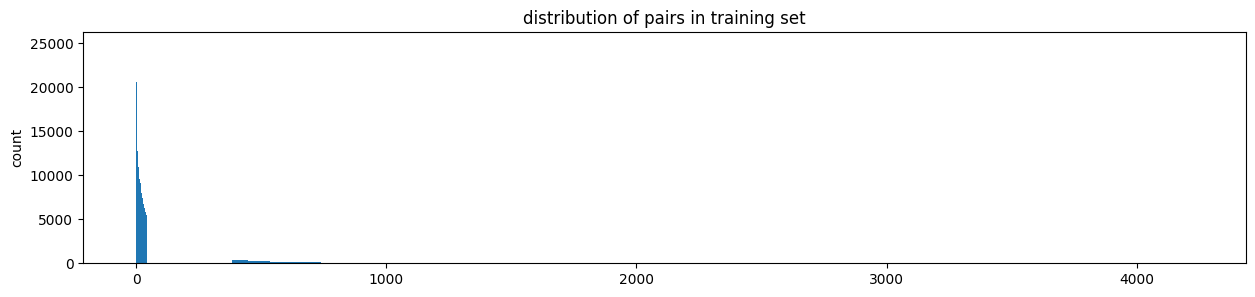

tensor(1003598)


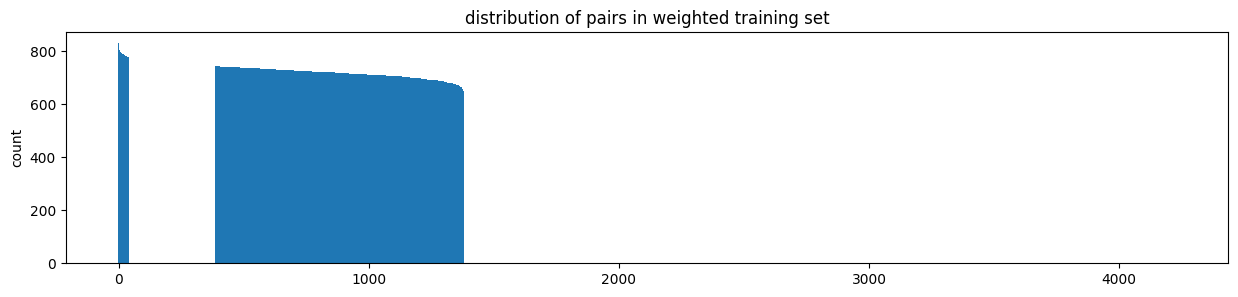

tensor(1003598)


In [13]:
def classes_count(vocab_size, data_loader):
    cl_cnt = torch.zeros(vocab_size*vocab_size, dtype=torch.long)
    for _,yy in data_loader:
        a = yy[:,-2:] @ torch.tensor([1, vocab_size])
        cl_cnt = cl_cnt.scatter_add(0, a, torch.ones_like(a))
    return cl_cnt

cl_cnt1 = classes_count(vocab_size, training_generator)
cl_cnt2 = classes_count(vocab_size, weighted_training_generator)

sorted2, indices2 = torch.sort(cl_cnt1, descending=True)
plot_pairs(sorted2, "distribution of pairs in training set")
print(sorted2.sum())
sorted2, indices2 = torch.sort(cl_cnt2, descending=True)
plot_pairs(sorted2, "distribution of pairs in weighted training set")
print(sorted2.sum())


In [8]:
model = get_model()
optimizer = torch.optim.AdamW(model.parameters(), lr = config.learning_rate)

try:
    checkpoint = torch.load(config.model_path)
    print(f" train_loss: {checkpoint['train_loss']}")
    print(f" val_loss: {checkpoint['val_loss']}")

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #torch.set_rng_state(checkpoint['rng_state'])       
except:
    print("no checkpoint")
    pass

preds = expected_x_got_y(vocab_size, model, validation_generator)
sorted, _ = torch.sort(flatten(vocab_size, preds.long()), descending=True)
plot_pairs(sorted, "expected, no weighting")

no checkpoint


KeyboardInterrupt: 

In [ ]:
def plot(title, ini, fin, res):
    fig, ax = plt.subplots(figsize=(10,10))
    
    labels = decode(range(ini,fin))
    ax.set_xticks(np.arange(len(labels)), labels=labels)
    ax.set_yticks(np.arange(len(labels)), labels=labels)

    im = ax.imshow(res[ini:fin,ini:fin].cpu())
    fig.tight_layout()
    fig.colorbar(im)
    ax.set_title(title)
    #fig.tight_layout()    

    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, labels[i]+labels[j],
                        ha="center", va="center", color="w")

    plt.show()



plot("pair distribution no weight", 39, 65, preds) 
#model.train()

In [ ]:
model = get_model()
optimizer = torch.optim.AdamW(model.parameters(), lr = config.learning_rate)
config.use_wandb = True
config.name = "weighted training set"
train(model, optimizer, weighted_training_generator, config)

In [ ]:
preds = expected_x_got_y(vocab_size, model, validation_generator)
plot("pair distribution weighting", 39, 65, preds) 

In [ ]:
def data_distributions():
    res = torch.zeros([vocab_size, vocab_size], dtype=torch.long, device = device)
    for i in range(len(tokens)-1):
        res[tokens[i], tokens[i+1]] +=1
    return res




In [ ]:
data_dist = data_distributions()
preds = expected_x_got_y()



In [ ]:
plot("'xy' expected x but got y", 39, 65, preds)    


In [ ]:
def flatten(dist):
    out = torch.zeros([dist.shape[0]*dist.shape[1]], dtype=torch.long)
    print(out.shape)
    for i in range(dist.shape[0]):
        for j in range(dist.shape[1]):
            out[j*vocab_size+i] += dist[i,j].cpu()
    return out


sorted, _ = torch.sort(cc, descending=True)
plot_pairs(sorted)

sorted, _ = torch.sort(flatten(data_dist), descending=True)
plot_pairs(sorted)


In [ ]:
sorted, _ = torch.sort(flatten(preds.long()), descending=True)
plot_pairs(sorted)
    

In [ ]:
print (res)

In [ ]:
checkpoint = torch.load(config.model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f" train_loss: {checkpoint['train_loss']}")
print(f" val_loss: {checkpoint['val_loss']}")
#print(model.generate(1500))             
print(checkpoint["config"])

In [ ]:
preds = expected_x_got_y(vocab_size, model, validation_generator)
sorted, _ = torch.sort(flatten(preds.long()), descending=True)
plot_pairs(sorted)

In [ ]:
train(model, training_generator)